In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from statsmodels import api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, Input, Flatten
from keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Dense, TimeDistributed
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption, calculate_datetime_diffs
from tools import to_timeseries, get_task2
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# Configuration

In [2]:
SEQUENCE_SIZE = 512
SEQ_Y = 64
BATCH_SIZE = 512

# Data

In [3]:
def get_task2(y):
    n = y.shape[0]
    data = np.zeros((n, 1))

    for i in range(n):
        data[i] = (y[i].max())
        
    return data

In [4]:
dataset = load_household_power_consumption(hour_one_hot=True)
dataset = dataset.loc[:'2010-11']
dataset['active_power'] = dataset['active_power'].rolling(window=15).mean()
dataset['active_power_max'] = dataset['active_power'].rolling(window=15).max()
# dataset['active_power_std'] = dataset['active_power'].rolling(window=12).std()

dataset['active_power2'] = dataset['active_power']**2
dataset['active_power3'] = dataset['active_power']**3
dataset['active_power4'] = dataset['active_power']**4
dataset = dataset.dropna()

data_x, data_y = split_x_y(dataset, SEQUENCE_SIZE)
diff_x, diff_y = split_x_y(calculate_datetime_diffs(dataset), SEQUENCE_SIZE)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x, diff_x, t=SEQUENCE_SIZE), 
    to_timeseries(data_y, diff_y, t=SEQUENCE_SIZE), 
    train_ratio=0.93)

train_y = train_y[:, :SEQ_Y]
test_y = test_y[:, :SEQ_Y]

train_y2 = get_task2(train_y)
test_y2 =  get_task2(test_y)

display(dataset[['active_power', 'reactive_power', 'voltage', 'intensity', 'sub1',
                 'sub2', 'sub3', 'h_0', 'h_1', 'h_23']].head())


print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print()
print('diff_x:', diff_x.shape)
print('diff_y:', diff_y.shape)
print()
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print()
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-30 17:56:33,750 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,h_0,h_1,h_23
datetime,,,,,,,,,,
2010-10-27 14:08:00,0.600000,0.076,248.18,2.2,0.0,0.0,0.0,0,0,0
2010-10-27 14:09:00,0.592667,0.078,247.57,2.2,0.0,0.0,1.0,0,0,0
2010-10-27 14:10:00,0.587867,0.048,246.99,2.4,0.0,0.0,1.0,0,0,0
2010-10-27 14:11:00,0.586000,0.000,247.44,2.4,0.0,0.0,0.0,0,0,0
2010-10-27 14:12:00,0.584400,0.000,248.37,2.4,0.0,0.0,1.0,0,0,0


data_x: (41662, 35)
data_y: (41662, 1)

diff_x: (41662, 1)
diff_y: (41662, 1)

train_x: (33042, 512, 35)
train_y: (33042, 64, 1)

test_x: (2488, 512, 35)
test_y: (2488, 64, 1)


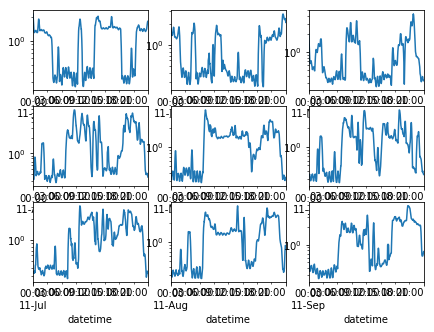

In [6]:
def show_active_power():
    fig, plots = subplots(3, 3)
    plots = plots.reshape(-1)
    fig.set_figheight(5)
    fig.set_figwidth(7)

    for i, p in enumerate(plots):
        i += 1
        dataset['active_power'].loc[f'2010-{i:02}'].plot(logy=True, ax=p)
        
show_active_power()

파란색 그래프가 보이면 안됩니다.
파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거


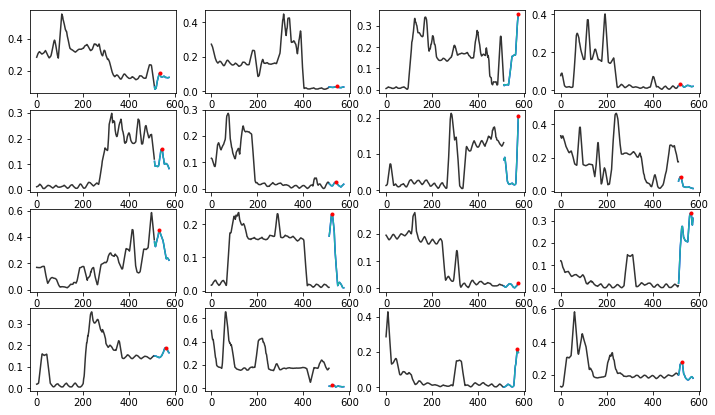

In [7]:
def vis_dataset(x, y, y2):
    n = x.shape[0]
    seq_n = x.shape[1]
    seq_n2 = y.shape[1]
    
    fig, plots = pylab.subplots(4, 4)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    plots = plots.reshape(-1)

    for p in plots:
        idx = np.random.randint(0, n-SEQUENCE_SIZE)
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n*2)
        x3 = np.arange(seq_n, seq_n + seq_n2)
        max_idx = np.where(y[idx, :, 0] == train_y[idx, :, 0].max())[0][0]
        
        p.plot(x1, x[idx, :, 0], label='input', color='#333333')
        p.plot(x3, x[idx+SEQUENCE_SIZE, :SEQ_Y, 0], label='output', color='blue')
        p.plot(x3, y[idx, :, 0], label='output', color='LightSeaGreen')
        p.plot(seq_n + max_idx, y[idx, max_idx, 0], marker='.', color='red')
        
print('파란색 그래프가 보이면 안됩니다.')
print('파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거')
vis_dataset(train_x, train_y, train_y2)

# Models

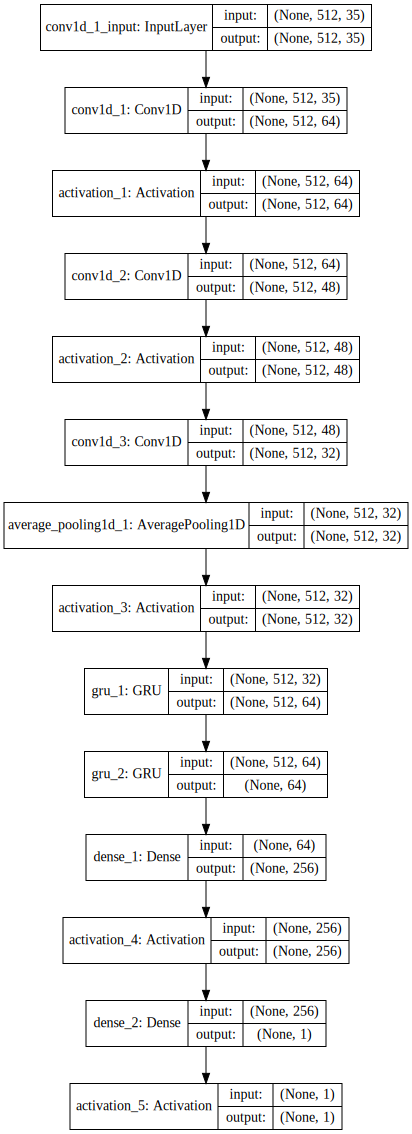

In [5]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=64, l2=64, n_input=31):
    np.random.seed(0)
    model = Sequential()
    model.add(Conv1D(64, kernel_size=8, padding='same', input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(Activation('relu'))
    
    model.add(Conv1D(48, kernel_size=5, padding='same'))
    model.add(Activation('relu'))
    
    model.add(Conv1D(32, kernel_size=3, padding='same'))
    model.add(AvgPool1D(2, strides=1, padding='same'))
    model.add(Activation('relu'))
    
    model.add(GRU(l1, return_sequences=True, recurrent_dropout=0.15))
    model.add(GRU(l1, recurrent_dropout=0.1))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.add(Activation('linear'))
    
    model.compile(loss='mean_squared_error', optimizer=Adam(clipnorm=1.), metrics=[r2])
    return model

model = create_model(64, 64, n_input=35)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [6]:
history = History()
%time model.fit(train_x, train_y2, epochs=3, batch_size=BATCH_SIZE, verbose=2, validation_data=(test_x, test_y2), callbacks=[history])

Train on 33042 samples, validate on 2488 samples
Epoch 1/3
90s - loss: 0.0182 - r2: 0.2924 - val_loss: 0.0071 - val_r2: 0.5329
Epoch 2/3
88s - loss: 0.0140 - r2: 0.4591 - val_loss: 0.0078 - val_r2: 0.4886
Epoch 3/3
88s - loss: 0.0124 - r2: 0.5180 - val_loss: 0.0072 - val_r2: 0.5252
CPU times: user 6min 24s, sys: 43.8 s, total: 7min 7s
Wall time: 4min 27s


# Evaluation

In [11]:
%time eval_results = model.evaluate(test_x, test_y2, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 1.56 s, sys: 192 ms, total: 1.76 s
Wall time: 1.71 s
loss: 0.007236518624607007
r2: 0.5185604216201513


In [12]:
pred_y = model.predict(test_x)
score = r2_score(test_y2.reshape(-1), pred_y.reshape(-1))
sigma = ((test_y2 - pred_y)**2).std()

print('r^2 score:', score)
print('Residual standard deviation:', sigma)

r^2 score: 0.645831071763
Residual standard deviation: 0.0121751698265


MSE: 0.01108 [ 0.17107376] [ 0.27633804]
MSE: 0.0005781 [ 0.23489119] [ 0.2108469]
MSE: 7.492e-05 [ 0.02644255] [ 0.03509825]
MSE: 2.841e-05 [ 0.44911346] [ 0.44378352]
MSE: 0.0003189 [ 0.01557856] [ 0.03343562]
MSE: 0.0004879 [ 0.02155717] [ 0.04364528]
MSE: 0.004563 [ 0.24250965] [ 0.17495874]
MSE: 0.01687 [ 0.38259711] [ 0.51249135]
MSE: 0.001371 [ 0.18861672] [ 0.15158977]
MSE: 0.0001663 [ 0.01361416] [ 0.02651118]
MSE: 0.004564 [ 0.19898534] [ 0.13142711]
MSE: 0.005537 [ 0.12725906] [ 0.20166868]
MSE: 0.0006234 [ 0.25269038] [ 0.27765852]
MSE: 0.007844 [ 0.33039527] [ 0.24182665]
MSE: 0.001325 [ 0.01655222] [ 0.05295889]
MSE: 0.007358 [ 0.24023778] [ 0.32601425]


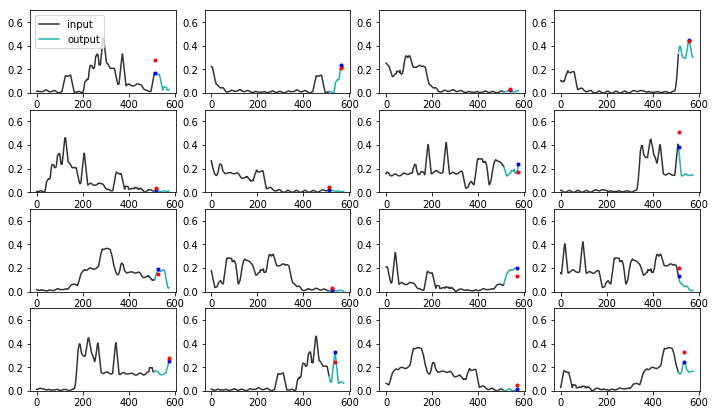

In [24]:
def vis_evaluate(model, test_x, test_y, test_y2, batch=32):
    n = len(test_x)
    seq_n = test_x.shape[1]
    seq_n2 = test_y.shape[1]

    fig, plots = pylab.subplots(4, 4)
    plots = plots.reshape(-1)

    fig.set_figwidth(12)
    fig.set_figheight(7)
    
    rng = np.linspace(0, test_x.shape[0]-1, 16, dtype='int')
    np.random.shuffle(rng)
    for i, p in enumerate(plots):
#         idx = np.random.randint(0, n)
        idx = rng[i]
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n + seq_n2)

        true_y = test_y[idx]
        pred_y = model.predict(test_x[idx:idx + 1], batch_size=batch)
        max_idx = np.where(test_y[idx, :, 0] == test_y[idx, :, 0].max())[0][0]
        
        score = mean_squared_error(test_y2[idx], pred_y.reshape(-1))
        print(f'MSE: {score:7.4}', test_y2[idx], pred_y.reshape(-1))
        
        p.set_ylim(0, 0.7)
        p.plot(x1, test_x[idx, :, 0], label='input', color='#333333')
        p.plot(x2, test_y[idx, :, 0], label='output', color='LightSeaGreen')
        p.plot(seq_n + max_idx, test_y[idx, max_idx, 0], marker='.', color='blue')
        p.plot(seq_n + max_idx, pred_y[0, 0], marker='.', color='red')
        
        if i == 0:
            p.legend()

vis_evaluate(model, test_x, test_y, test_y2, batch=BATCH_SIZE)